# Feeltrace and calibrated words analysis
Rubia Guerra

Last updated: Apr 16th 2022

TODO: Fix participant mappings (P2, P3... P20) -> (P1...P16)

## Module definitions

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import re
import pandas as pd
import scipy.io as sio
import seaborn as sns
from scipy import signal
from statsmodels.tsa import stattools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

from tqdm import tqdm

plt.style.use("seaborn")

%matplotlib inline

## Import data

In [224]:
def load_dataset(data_dir = '../EEG/data/p*'):
    feeltrace_data_files = glob.glob(os.path.join(data_dir, 'joystick.mat'))
    feeltrace_data_files.sort()
    
    feeltrace_data = []
    for subject_filename in feeltrace_data_files:
        mat_contents = sio.loadmat(subject_filename)
        df = pd.DataFrame(mat_contents['var'], columns=['Timestamps', 'Feeltrace'])
        p_number = [re.findall('p\d+', subject_filename)[0].strip('p')] * df.shape[0]
        df['p_number'] = p_number
        feeltrace_data.append(df)
    
    subject_data_files = glob.glob(os.path.join(data_dir, 'calibrated_words_calibrated_values.mat'))
    subject_data_files.sort()

    timestamps_data_files = glob.glob(os.path.join(data_dir, 'calibrated_words_time*.mat'))
    timestamps_data_files.sort()
    
    subjects_data = []
    for subject_filename, timestamp_filename in zip(subject_data_files, timestamps_data_files):
        subject_data = (sio.loadmat(subject_filename)['var'].ravel() + 10)*10
        timestamp_data = sio.loadmat(timestamp_filename)['var'].ravel()

        df_data = list(zip(timestamp_data, subject_data))        
        df = pd.DataFrame(df_data, columns=['Timestamps', 'Values'])

        p_number = [re.findall('p\d+', subject_filename)[0].strip('p')] * df.shape[0]
        df['p_number'] = p_number
        subjects_data.append(df)
    
    return subjects_data, feeltrace_data

In [225]:
[words_list, feeltrace_list] = load_dataset()

In [226]:
words_df = pd.concat(words_list)
feeltrace_df = pd.concat(feeltrace_list)

In [239]:
feeltrace_df.p_number.unique()

array(['10', '12', '13', '15', '17', '19', '2', '20', '22', '23', '4',
       '5', '6', '7', '8', '9'], dtype=object)

In [240]:
pd.concat(words_list).head()

,Timestamps,Values,p_number
0,41100,100.0,10
1,66900,110.0,10
2,86833,185.0,10
3,109466,185.0,10
4,152233,115.0,10


In [241]:
pd.concat(feeltrace_list).head()

,Timestamps,Feeltrace,p_number
0,9437.0,74.0,10
1,9451.0,74.0,10
2,9471.0,74.0,10
3,9511.0,75.0,10
4,9548.0,74.0,10


## Single participant

Testing code with a single subject

### Downsampling the continuous annotation

Before time series analysis can be performed, we must downsample the feeltrace to match the sample size of the interview words (or upsample the interview words):
- $\text{Fs}_{\text{feeltrace}} = 30$Hz
- $\text{Fs}_{\text{calibrated words}} \approx 0.05$Hz

In [242]:
def scale(X, min_=0, max_=200):
    return (X - min_)/(max_ - min_)

In [243]:
p10_words = words_list[0].copy()
p10_feeltrace = feeltrace_list[0].copy()

p10_words.Values = scale(p10_words.Values)
p10_feeltrace.Feeltrace = scale(p10_feeltrace.Feeltrace)

In [244]:
p10_words.Timestamps.count()/(p10_words.Timestamps.iloc[-1]*1e-3)

0.040934900303710546

In [245]:
p10_feeltrace.Timestamps.count()/(p10_feeltrace.Timestamps.iloc[-1]*1e-3)

29.64152332829802

Here, I attempt downsampling the feeltrace using aggregation strategies. I am using windows corresponding to midpoints in between sampled words. For instance, if the first interview word is recorded at $t=10$s and the next word is recorded at $t=15$s, the first window corresponds to $t=0$s to $t=12.5$s.

We can calculate windows using a rolling average on the interview timestamps.

In [246]:
timestamps = p10_words.Timestamps.rolling(2).mean().dropna().reset_index(drop=True)
timestamps.head()

0     54000.0
1     76866.5
2     98149.5
3    130849.5
4    158899.5
Name: Timestamps, dtype: float64

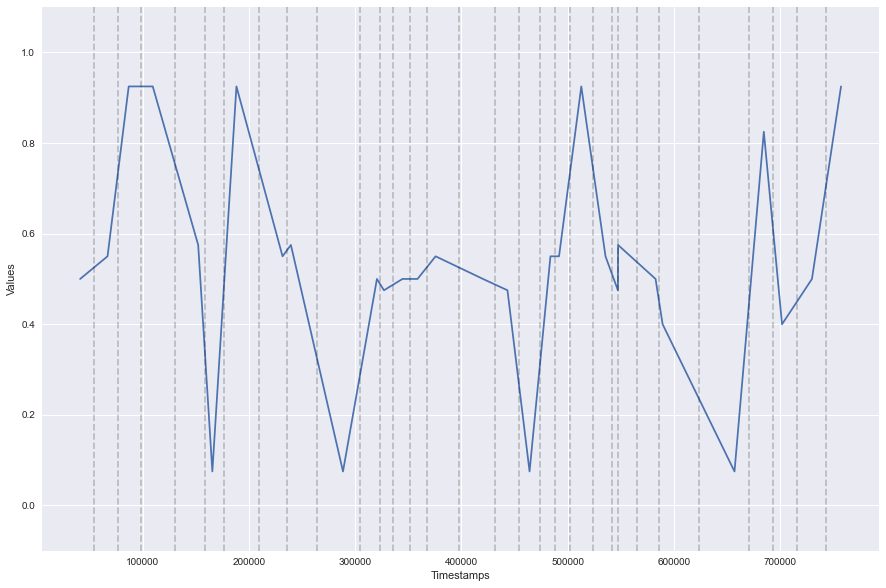

In [247]:
plt.figure(figsize=(15,10))
sns.lineplot(data=p10_words, x='Timestamps', y='Values')
plt.ylim([-.1, 1.1])

for x in timestamps:
    plt.axvline(x, c='k', alpha=0.2, linestyle='dashed')

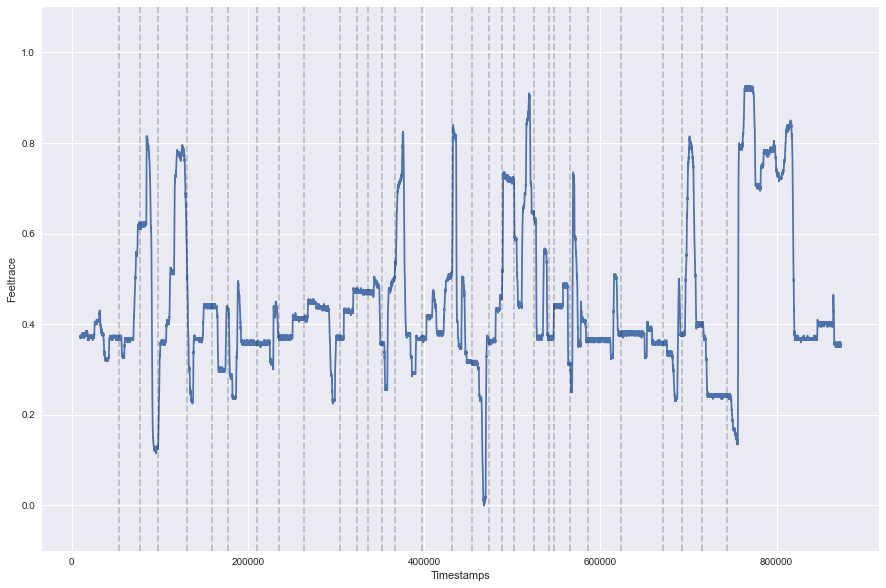

In [248]:
plt.figure(figsize=(15,10))
sns.lineplot(data=p10_feeltrace, x='Timestamps', y='Feeltrace')
plt.ylim([-.1, 1.1])

for x in timestamps:
    plt.axvline(x, c='k', alpha=0.2, linestyle='dashed')

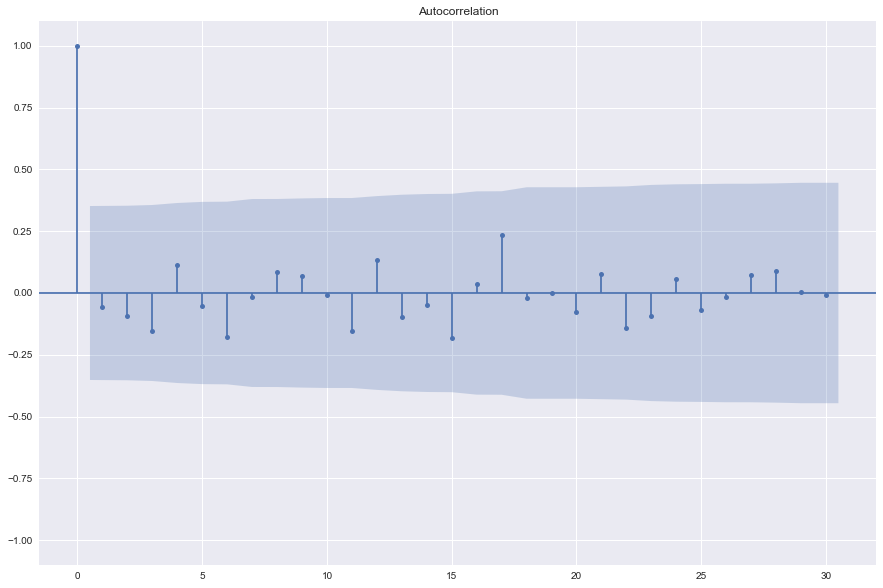

In [249]:
from statsmodels.graphics.tsaplots import plot_acf

plt.rc('figure', figsize=(15,10))
plot_acf(p10_words['Values'], lags=range(len(p10_words)))
plt.ylim([-1.1, 1.1]);

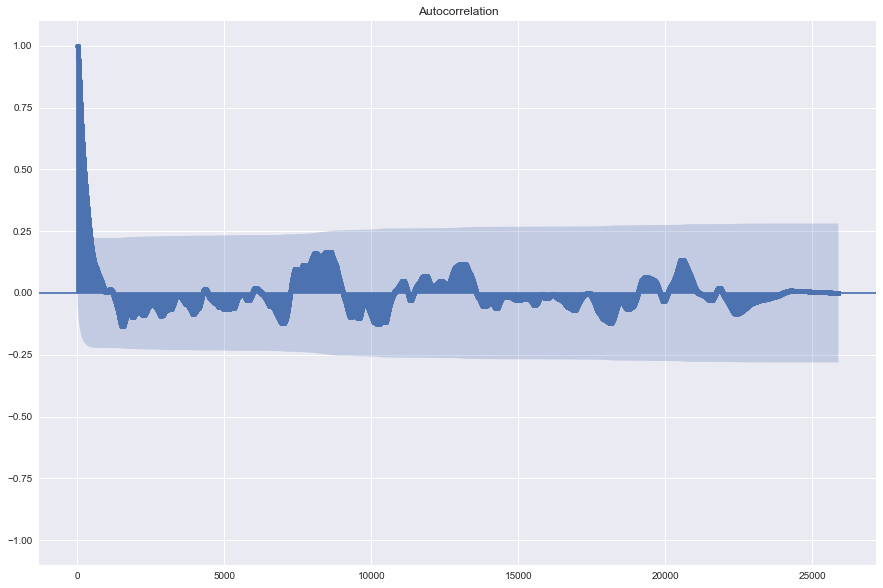

In [250]:
plt.rc('figure', figsize=(15,10))
plot_acf(p10_feeltrace['Feeltrace'], lags=range(len(p10_feeltrace)))
plt.ylim([-1.1, 1.1]);

Extract indexes in the feeltrace by looking at the nearest timestamp that matches our window start points:

In [17]:
idxs = []

for timestamp in timestamps:
    arr = p10_feeltrace.Timestamps.to_numpy().astype(int)
    dist = (arr - timestamp)**2
    idx = tuple(np.argwhere(dist == np.min(dist))[0])
    idxs.append(idx[0])

print(f'Indexes: %s' % idxs)

Indexes: [1331, 2024, 2641, 3629, 4477, 5016, 6008, 6779, 7638, 8859, 9432, 9794, 10266, 10732, 11658, 12617, 13246, 13851, 14264, 14702, 15357, 15873, 16053, 16588, 17221, 18343, 19784, 20457, 21141, 21975]


Timestamps for the new feeltrace are defined as the mean timestamp of the window ((window start + window end) / 2):

In [18]:
feeltrace_timestamps = list(p10_feeltrace.loc[idxs, 'Timestamps'].rolling(2).mean().reset_index(drop=True))

# add first timestamp
feeltrace_timestamps[0] = p10_feeltrace.loc[idxs[0], 'Timestamps'] / 2

# add last timestamp
feeltrace_timestamps.append((p10_feeltrace.Timestamps.iloc[-1] + p10_feeltrace.loc[idxs[-1], 'Timestamps']) / 2)

feeltrace_timestamps = pd.Series(feeltrace_timestamps)

print(f'Timestamps (ms): %s' % feeltrace_timestamps.head())

Timestamps (ms): 0     26996.0
1     65427.0
2     87506.5
3    114499.5
4    144872.5
dtype: float64


In [19]:
# make sure both series are the same length
assert(len(feeltrace_timestamps) == len(p10_words.Timestamps))

Now, I explore aggregating the feeltrace in two ways:
- By taking the mean value of all points in window
- By calculating the overall direction of change in the feeltrace (slope)

#### Aggregating by taking the mean

In [20]:
p10_feeltrace_agg_mean = pd.DataFrame()

mean_feeltrace = []

# first window
mean_feeltrace.append(p10_feeltrace.Feeltrace.loc[:idxs[0]].mean())

# middle windows
for (prev_idx, idx) in zip(idxs[:-1], idxs[1:]):
    mean_feeltrace.append(p10_feeltrace.Feeltrace.loc[prev_idx:idx].mean())

# last window
mean_feeltrace.append(p10_feeltrace.Feeltrace.loc[idxs[-1]:].mean())

# make sure both feeltrace and interview series are the same size
assert(len(mean_feeltrace) == len(p10_words.Values))

p10_feeltrace_agg_mean['Timestamps'] = feeltrace_timestamps
p10_feeltrace_agg_mean['Feeltrace'] = mean_feeltrace

In [21]:
p10_feeltrace_agg_mean.head()

,Timestamps,Feeltrace
0,26996.0,0.372654
1,65427.0,0.413613
2,87506.5,0.490906
3,114499.5,0.552672
4,144872.5,0.375592


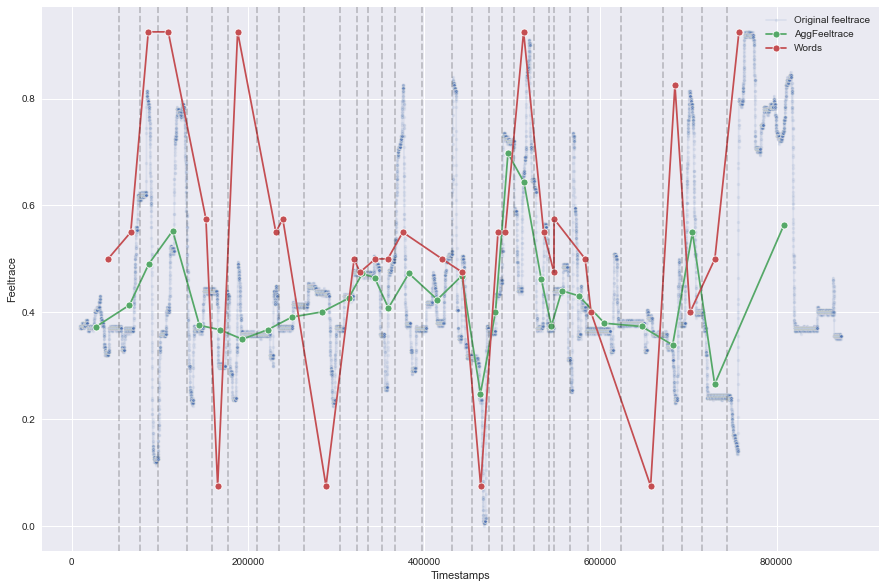

In [22]:
plt.figure(figsize=(15,10))

sns.lineplot(data=p10_feeltrace, x='Timestamps', y='Feeltrace', marker='.', alpha=0.1)
sns.lineplot(data=p10_feeltrace_agg_mean, x='Timestamps', y='Feeltrace', marker='o')
sns.lineplot(data=p10_words, x='Timestamps', y='Values', marker='o')
plt.legend(['Original feeltrace', 'AggFeeltrace', 'Words']);

for x in timestamps:
    plt.axvline(x, c='k', alpha=0.2, linestyle='dashed')

Checking autocorelation on aggregated data:

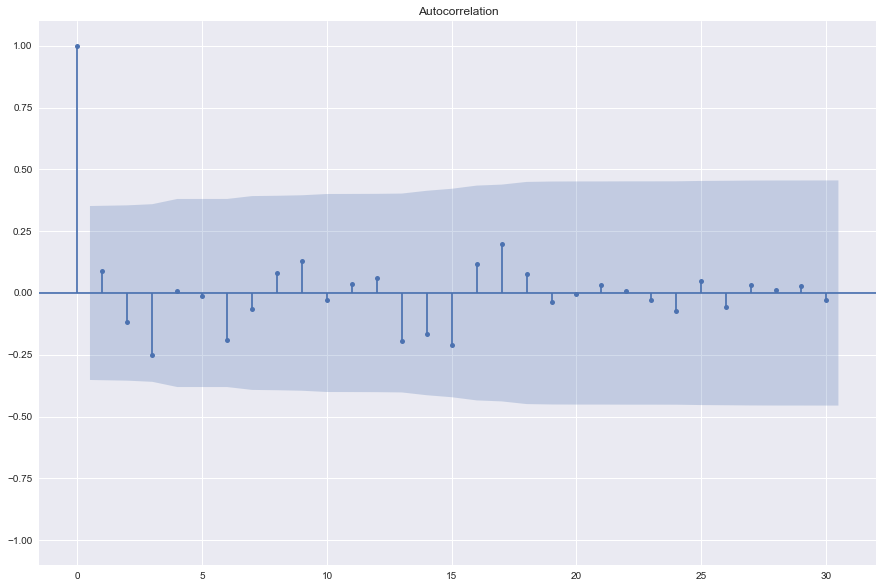

In [23]:
plt.rc('figure', figsize=(15,10))
plot_acf(p10_feeltrace_agg_mean['Feeltrace'], lags=range(len(p10_feeltrace_agg_mean)))
plt.ylim([-1.1, 1.1]);

#### Aggregating by taking the slope

Trying to bin state transitions in three values:
- Increase in stress level (+1)
- Neutral (0)
- Decrease in stress level (-1)

Tried a few attemps, settling for taking first and last value of window:

In [24]:
def change_direction(x, y):
    def slope(x):
        slope = np.polyfit(range(len(x)), x, 1)[0]
        return slope
       
    def slope_angle(x, y):
        x = np.array(x)
        y = np.array(y)
        angle = np.arctan2(y[-1] - y[0], x[-1] - x[0])
        return angle
    
    def slope_sign(x, factor=1e3):
        if np.round(slope(x)*factor): 
            return np.sign(slope(x)*factor) 
        else: 
            return 0
        
    def first_last(x):
        diff = np.round(x.iloc[-1] - x.iloc[0],1)
        if diff:
            return np.sign(diff)
        else:
            return 0
       
    return first_last(x)

Calculating for feeltrace:

In [25]:
p10_feeltrace_agg_slope = pd.DataFrame()

slope_feeltrace = []

# first window
slope_feeltrace.append(change_direction(p10_feeltrace.Feeltrace[:idxs[0]], p10_feeltrace.Timestamps[:idxs[0]]))

# middle windows
for (prev_idx, idx) in zip(idxs[:-1], idxs[1:]):
    slope_feeltrace.append(change_direction(p10_feeltrace.Feeltrace.loc[prev_idx:idx], p10_feeltrace.Timestamps.loc[prev_idx:idx]))

# last window
slope_feeltrace.append(change_direction(p10_feeltrace.Feeltrace.loc[idxs[-1]:], p10_feeltrace.Timestamps.loc[idxs[-1]:]))

# make sure both feeltrace and interview series are the same size
assert(len(slope_feeltrace) == len(p10_words.Values))

p10_feeltrace_agg_slope['Timestamps'] = feeltrace_timestamps
p10_feeltrace_agg_slope['Feeltrace'] = slope_feeltrace
p10_feeltrace_agg_slope.head()

,Timestamps,Feeltrace
0,26996.0,0.0
1,65427.0,1.0
2,87506.5,-1.0
3,114499.5,1.0
4,144872.5,-1.0


Also calculating the slope values based on the aggregated feeltrace data:

In [26]:
p10_feeltrace_agg_mean_slope = pd.DataFrame()

mean_feeltrace_words = []
indexes = list(p10_feeltrace_agg_mean.index)

# middle windows
for (prev_idx, idx) in zip(indexes[:-1], indexes[1:]):
    mean_feeltrace_words.append(change_direction(p10_feeltrace_agg_mean.Feeltrace.loc[prev_idx:idx], p10_feeltrace_agg_mean.Timestamps.loc[prev_idx:idx]))

p10_feeltrace_agg_mean_slope['Feeltrace'] = mean_feeltrace_words
p10_feeltrace_agg_mean_slope['Timestamps'] = timestamps
p10_feeltrace_agg_mean_slope.head()

,Feeltrace,Timestamps
0,0.0,54000.0
1,1.0,76866.5
2,1.0,98149.5
3,-1.0,130849.5
4,0.0,158899.5


Taking the slopes for interview words:

In [27]:
p10_words_agg_slope = pd.DataFrame()

slope_words = []
indexes = list(p10_words.index)

# middle windows
for (prev_idx, idx) in zip(indexes[:-1], indexes[1:]):
    slope_words.append(change_direction(p10_words.Values.loc[prev_idx:idx], p10_words.Timestamps.loc[prev_idx:idx]))

p10_words_agg_slope['Values'] = slope_words
p10_words_agg_slope['Timestamps'] = timestamps
p10_words_agg_slope.head()

,Values,Timestamps
0,1.0,54000.0
1,1.0,76866.5
2,0.0,98149.5
3,-1.0,130849.5
4,-1.0,158899.5


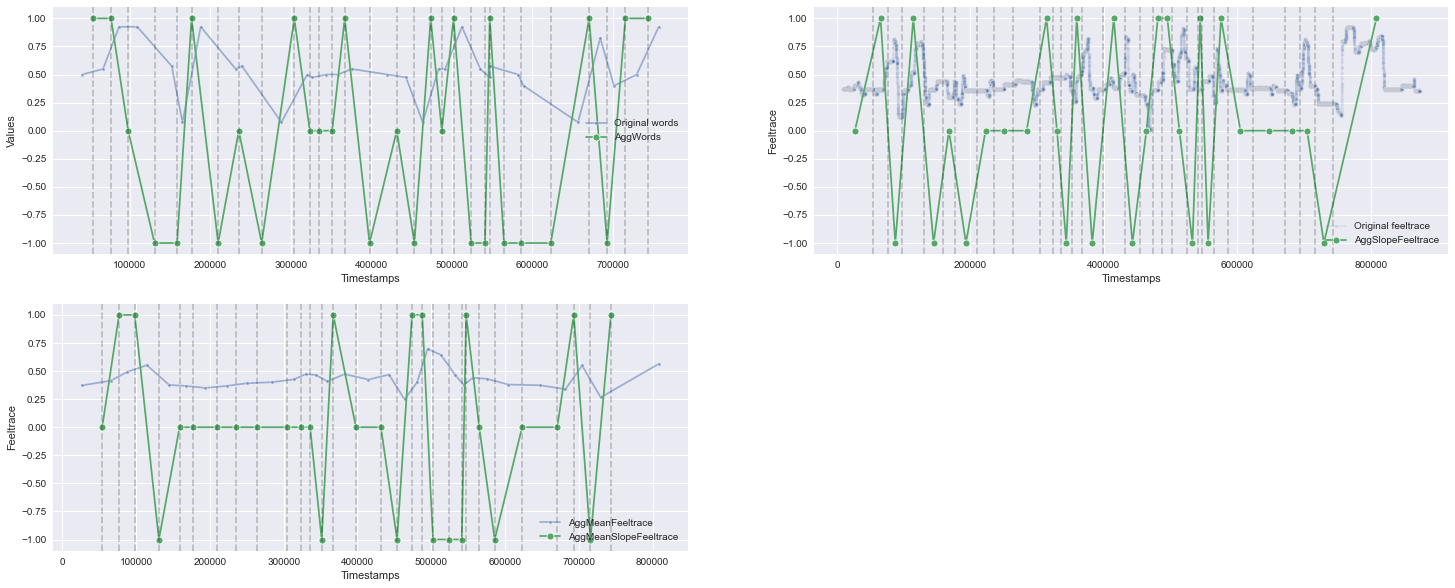

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(25,10))

sns.lineplot(data=p10_words, x='Timestamps', y='Values', marker='.', alpha=0.5, ax=axes[0,0])
sns.lineplot(data=p10_words_agg_slope, y='Values', x='Timestamps', marker='o', ax=axes[0,0]);
axes[0,0].legend(['Original words', 'AggWords']);

sns.lineplot(data=p10_feeltrace, x='Timestamps', y='Feeltrace', marker='.', alpha=0.1, ax=axes[0,1])
sns.lineplot(data=p10_feeltrace_agg_slope, y='Feeltrace', x='Timestamps', marker='o', ax=axes[0,1]);
axes[0,1].legend(['Original feeltrace', 'AggSlopeFeeltrace']);

sns.lineplot(data=p10_feeltrace_agg_mean, x='Timestamps', y='Feeltrace', marker='.', alpha=0.5, ax=axes[1,0])
sns.lineplot(data=p10_feeltrace_agg_mean_slope, y='Feeltrace', x='Timestamps', marker='o', ax=axes[1,0]);
axes[1,0].legend(['AggMeanFeeltrace', 'AggMeanSlopeFeeltrace']);

fig.delaxes(axes[1,1])

for x in timestamps:
    axes[0,0].axvline(x, c='k', alpha=0.2, linestyle='dashed')
    axes[0,1].axvline(x, c='k', alpha=0.2, linestyle='dashed')
    axes[1,0].axvline(x, c='k', alpha=0.2, linestyle='dashed')

To proceed with analysis, I will be comparing the transitions captured by word labels and by the aggregated feeltrace values.

In [29]:
p10_agg_data = pd.DataFrame()
p10_agg_data['Timestamps'] = p10_words_agg_slope['Timestamps'].copy()
p10_agg_data['Words'] = p10_words_agg_slope['Values'].copy()
p10_agg_data['Feeltrace'] = p10_feeltrace_agg_mean_slope['Feeltrace'].copy()

p10_agg_data.head()

,Timestamps,Words,Feeltrace
0,54000.0,1.0,0.0
1,76866.5,1.0,1.0
2,98149.5,0.0,1.0
3,130849.5,-1.0,-1.0
4,158899.5,-1.0,0.0


Checking autocorelation on aggregated data:

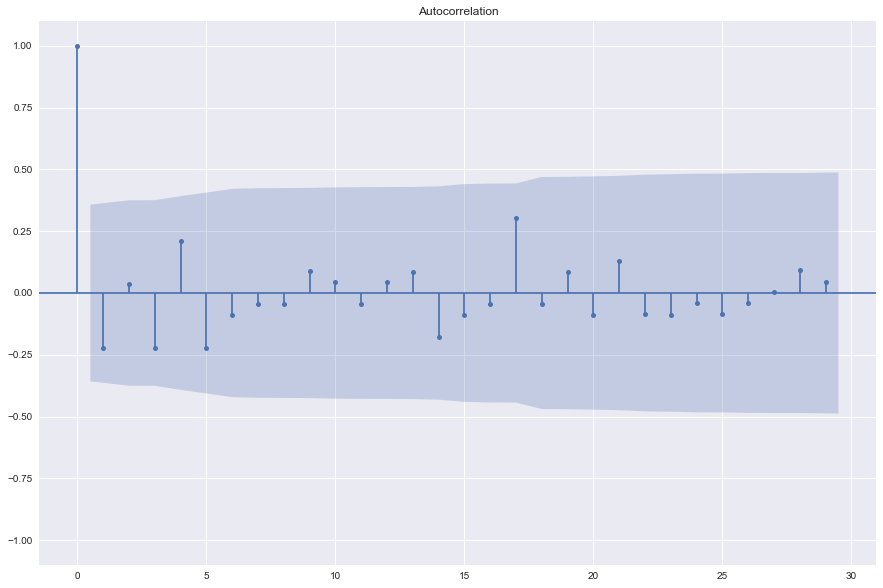

In [30]:
plt.rc('figure', figsize=(15,10))
plot_acf(p10_words_agg_slope['Values'], lags=range(len(p10_words_agg_slope)))
plt.ylim([-1.1, 1.1]);

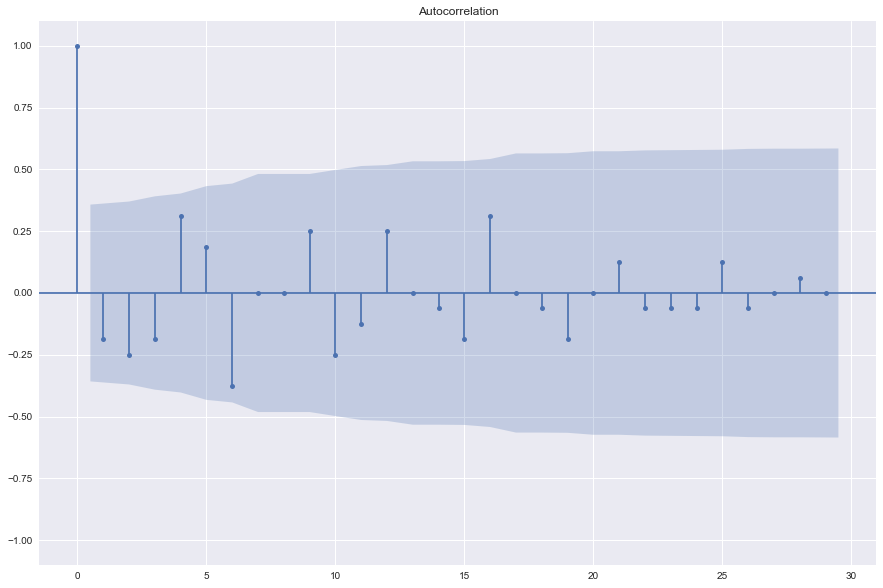

In [31]:
plt.rc('figure', figsize=(15,10))
plot_acf(p10_feeltrace_agg_mean_slope['Feeltrace'], lags=range(len(p10_feeltrace_agg_mean_slope)))
plt.ylim([-1.1, 1.1]);

### Joint time series analysis

Refer to _Ernst AF, Timmerman ME, Jeronimus BF, Albers CJ. Insight into individual differences in emotion dynamics with clustering. Assessment. 2021 Jun;28(4):1186-206._

*Adapted from [BioSciEconomist/ex VAR.py](https://gist.github.com/BioSciEconomist/197bd86ea61e0b4a49707af74a0b9f9c).

#### Granger Causality

The results of Granger Causality for P10 are promising, suggeting a significant relationship* between interview words and feeltrace.

*(potentially a causality relationship, although this might be too strong of a claim, see `Limitations` section below)

In [32]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag = 1
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [np.round(test_result[i+1][0][test][1], 5) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            if not min_p_value:
                raise ValueError
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

while True:
    try:
        grangers_causation_matrix(p10_agg_data[['Words', 'Feeltrace']], variables = p10_agg_data[['Words', 'Feeltrace']].columns, verbose=False) 
        maxlag+=1
    except ValueError:
        maxlag-=1
        grangers_causation_matrix(p10_agg_data[['Words', 'Feeltrace']], variables = p10_agg_data[['Words', 'Feeltrace']].columns, verbose=True) 
        print(maxlag)
        break

# notes: 
# The row are the Response (Y) and the columns are the predictor series (X).

# For example, if you take the value 0.0021 in (row 1, column 2), it refers to 
# the p-value of Feeltrace_x causing Words_y.

Y = Words, X = Words, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Y = Feeltrace, X = Words, P Values = [0.0395, 0.1126, 0.0887, 0.1401, 0.1874, 0.3395, 0.0001, 0.0]
Y = Words, X = Feeltrace, P Values = [0.9161, 0.8378, 0.9315, 0.4438, 0.0869, 0.0579, 0.0188, 0.0021]
Y = Feeltrace, X = Feeltrace, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


,Words_x,Feeltrace_x
Words_y,1.0,0.0021
Feeltrace_y,0.0,1.0000


##### Limitations

(see https://en.wikipedia.org/wiki/Granger_causality#Limitations)

As its name implies, Granger causality is not necessarily true causality. In fact, the Granger-causality tests fulfill only the Humean definition of causality that identifies the cause-effect relations with constant conjunctions.[14] If both X and Y are driven by a common third process with different lags, one might still fail to reject the alternative hypothesis of Granger causality. Yet, manipulation of one of the variables would not change the other. Indeed, the Granger-causality tests are designed to handle pairs of variables, and may produce misleading results when the true relationship involves three or more variables. Having said this, it has been argued that given a probabilistic view of causation, Granger causality can be considered true causality in that sense, especially when Reichenbach's "screening off" notion of probabilistic causation is taken into account.[15] Other possible sources of misguiding test results are: (1) not frequent enough or too frequent sampling, (2) nonlinear causal relationship, (3) time series nonstationarity and nonlinearity and (4) existence of rational expectations.[14] A similar test involving more variables can be applied with vector autoregression. Recently [16] a fundamental mathematical study of the mechanism underlying the Granger method has been provided. By making use exclusively of mathematical tools (Fourier transformation and differential calculus), it has been found that not even the most basic requirement underlying any possible definition of causality is met by the Granger causality test: any definition of causality should refer to the prediction of the future from the past; instead by inverting the time series it can be shown that Granger allows one to ”predict” the past from the future as well. 

#### Cointegration

In [309]:
#-----------------------------------------
# cointegration
#-----------------------------------------

# When two or more time series are cointegrated, it means they have a long run, 
# statistically significant relationship.

# This is the basic premise on which Vector Autoregression(VAR) models is based on. 
# So, it’s fairly common to implement the cointegration test before starting to 
# build VAR models.

# more technically:
# Order of integration(d) is nothing but the number of differencing required to 
# make a non-stationary time series stationary.

# Now, when you have two or more time series, and there exists a linear combination
#  of them that has an order of integration (d) less than that of the individual 
# series, then the collection of series is said to be cointegrated.

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    results = []

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
        results.append({col: [trace, cvt, trace > cvt]})
        
    return results

cointegration_test(p10_agg_data[['Words', 'Feeltrace']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Words  ::  25.09     > 12.3212   =>   True
Feeltrace ::  5.58      > 4.1296    =>   True


[{'Words': [25.090662611093716, 12.3212, True]},
 {'Feeltrace': [5.576373930313893, 4.1296, True]}]

#### Stationarity

In [40]:
from statsmodels.tsa.stattools import adfuller

#------------------------------
# check for stationarity
#-----------------------------

# VAR model requires the time series you want to forecast to be stationary, 
# it is customary to check all the time series in the system for stationarity.

# Since, differencing reduces the length of the series by 1 and since all the 
# time series has to be of the same length, you need to difference all the series
#  in the system if you choose to difference at all.

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  
        
 # ADF Test on each column
for name, column in p10_agg_data.iteritems():
    if 'Timestamps' in name:
        continue
    adfuller_test(column, name=column.name)
    print('\n')    
    
diff = p10_agg_data.diff().dropna()

# ADF Test on each column
for name, column in diff.iteritems():
    if 'Timestamps' in name:
        continue
    adfuller_test(column, name=column.name)
    print('\n')   

    Augmented Dickey-Fuller Test on "Words" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6022
 No. Lags Chosen       = 0
 Critical value 1%     = -3.679
 Critical value 5%     = -2.968
 Critical value 10%    = -2.623
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Feeltrace" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5379
 No. Lags Chosen       = 5
 Critical value 1%     = -3.738
 Critical value 5%     = -2.992
 Critical value 10%    = -2.636
 => P-Value = 0.1065. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Words" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary

#### Pearson's correlation

In [36]:
p10_agg_data[['Words', 'Feeltrace']].corr()

,Words,Feeltrace
Words,1.000000,0.365165
Feeltrace,0.365165,1.000000


#### VAR Model

##### Training and validation data

In [55]:
# The VAR model will be fitted on df_train and then used to forecast the next 4 
# observations. These forecasts will be compared against the actuals present in 
# test data.


nobs = 4
df_train, df_test = p10_agg_data[0:-nobs], p10_agg_data[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(26, 3)
(4, 3)


##### Fitting

In [88]:
#---------------------------------------
# fitting the order of the VAR
#--------------------------------------

# To select the right order of the VAR model, we iteratively fit increasing orders 
# of VAR model and pick the order that gives a model with least AIC.

df_train_diff = df_train.diff().dropna()

model = VAR(df_train_diff[['Words', 'Feeltrace']])
for i in [1,2,3,4,5, 6, 7]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')


Lag Order = 1
AIC :  0.05775404864776357
BIC :  0.3522675062347499
FPE :  1.0622432071420118
HQIC:  0.13588855185103732 

Lag Order = 2
AIC :  0.0931959320852247
BIC :  0.5868890694457246
FPE :  1.1132639758642113
HQIC:  0.2173583723415481 

Lag Order = 3
AIC :  -0.27946635048747726
BIC :  0.41483339255872376
FPE :  0.7915973875719311
HQIC:  -0.11591020813616004 

Lag Order = 4
AIC :  -0.13823926468913883
BIC :  0.7570656819309383
FPE :  0.9802540411704659
HQIC:  0.05606482781369326 

Lag Order = 5
AIC :  -0.23709251936825293
BIC :  0.8582129815411368
FPE :  1.0371045407615151
HQIC:  -0.023277378565365936 

Lag Order = 6
AIC :  -2.3461160602640394
BIC :  -1.053725878246805
FPE :  0.176399265652843
HQIC:  -2.1273922931509723 

Lag Order = 7
AIC :  -4.035830765283158
BIC :  -2.5518778354562173
FPE :  0.07627778373435394
HQIC:  -3.831213665944237 



/Users/rubiarg/.virtualenvs/cpsc554x/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [89]:
# In the above output, the AIC drops to lowest at lag 4, then increases at 
# lag 5 and then continuously drops further. (more negative = 'smaller' AIC)

#---------------------------------
# alterntative: auto fit
#---------------------------------

x = model.select_order(maxlags=7)
x.summary()


,AIC,BIC,FPE,HQIC
0,0.6794,0.7783,1.973,0.6930
1,0.1607,0.4575,1.182,0.2016
2,0.1338,0.6285,1.178,0.2020
3,-0.7488,-0.05632,0.5156,-0.6533
4,-0.4248,0.4656,0.7965,-0.3020
5,-1.364,-0.2761,0.3806,-1.214
6,-2.820,-1.534,0.1275,-2.642
7,-4.036*,-2.552*,0.07628*,-3.831*


In [90]:
#----------------------------------
# fit VAR(5)
#---------------------------------

model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Apr, 2022
Time:                     18:39:04
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.55188
Nobs:                     18.0000    HQIC:                  -3.83121
Log likelihood:           15.2407    FPE:                  0.0762778
AIC:                     -4.03583    Det(Omega_mle):       0.0226942
--------------------------------------------------------------------
Results for equation Words
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.035169         0.153833           -0.229           0.819
L1.Words            -0.011307         0.532488           -0.021           0.983
L1.Feeltrace        -0.732441         0.520667           -1.407 

##### Check for remaining serial correlation

In [92]:
# Serial correlation of residuals is used to check if there is any leftover pattern 
# in the residuals (errors). If there is any correlation left in the residuals, then,
# there is some pattern in the time series that is still left to be explained by the
# model. In that case, the typical course of action is to either increase the order
# of the model or induce more predictors into the system or look for a different 
# algorithm to model the time series.

# A common way of checking for serial correlation of errors can be measured using 
# the Durbin Watson’s Statistic.

# The value of this statistic can vary between 0 and 4. The closer it is to the value 
# 2, then there is no significant serial correlation. The closer to 0, there is a 
# positive serial correlation, and the closer it is to 4 implies negative serial 
# correlation.

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

# for col, val in zip(df.columns, out):
#    print(adjust(col), ':', round(val, 2))
    
for col, val in zip(p10_agg_data[['Words', 'Feeltrace']].columns, out):
    print(col, ':', round(val, 2))

Words : 1.93
Feeltrace : 1.04


##### Forecasting

In [96]:
#--------------------------------------
# forecasting
#--------------------------------------

# In order to forecast, the VAR model expects up to the lag order number of 
# observations from the past data. This is because, the terms in the VAR model 
# are essentially the lags of the various time series in the dataset, so you 
# need to provide it as many of the previous values as indicated by the lag order
# used by the model.

# Get the lag order (we already know this)
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_train_diff[['Words', 'Feeltrace']].values[-lag_order:]
forecast_input

# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs) # nobs defined at top of program
df_forecast = pd.DataFrame(fc, index=p10_agg_data[['Words', 'Feeltrace']].index[-nobs:], columns=p10_agg_data[['Words', 'Feeltrace']].columns + '_1d')
df_forecast

7


,Words_1d,Feeltrace_1d
26,3.433782,-0.078952
27,-0.456890,1.890234
28,-3.966676,-4.530015
29,1.957641,0.401022


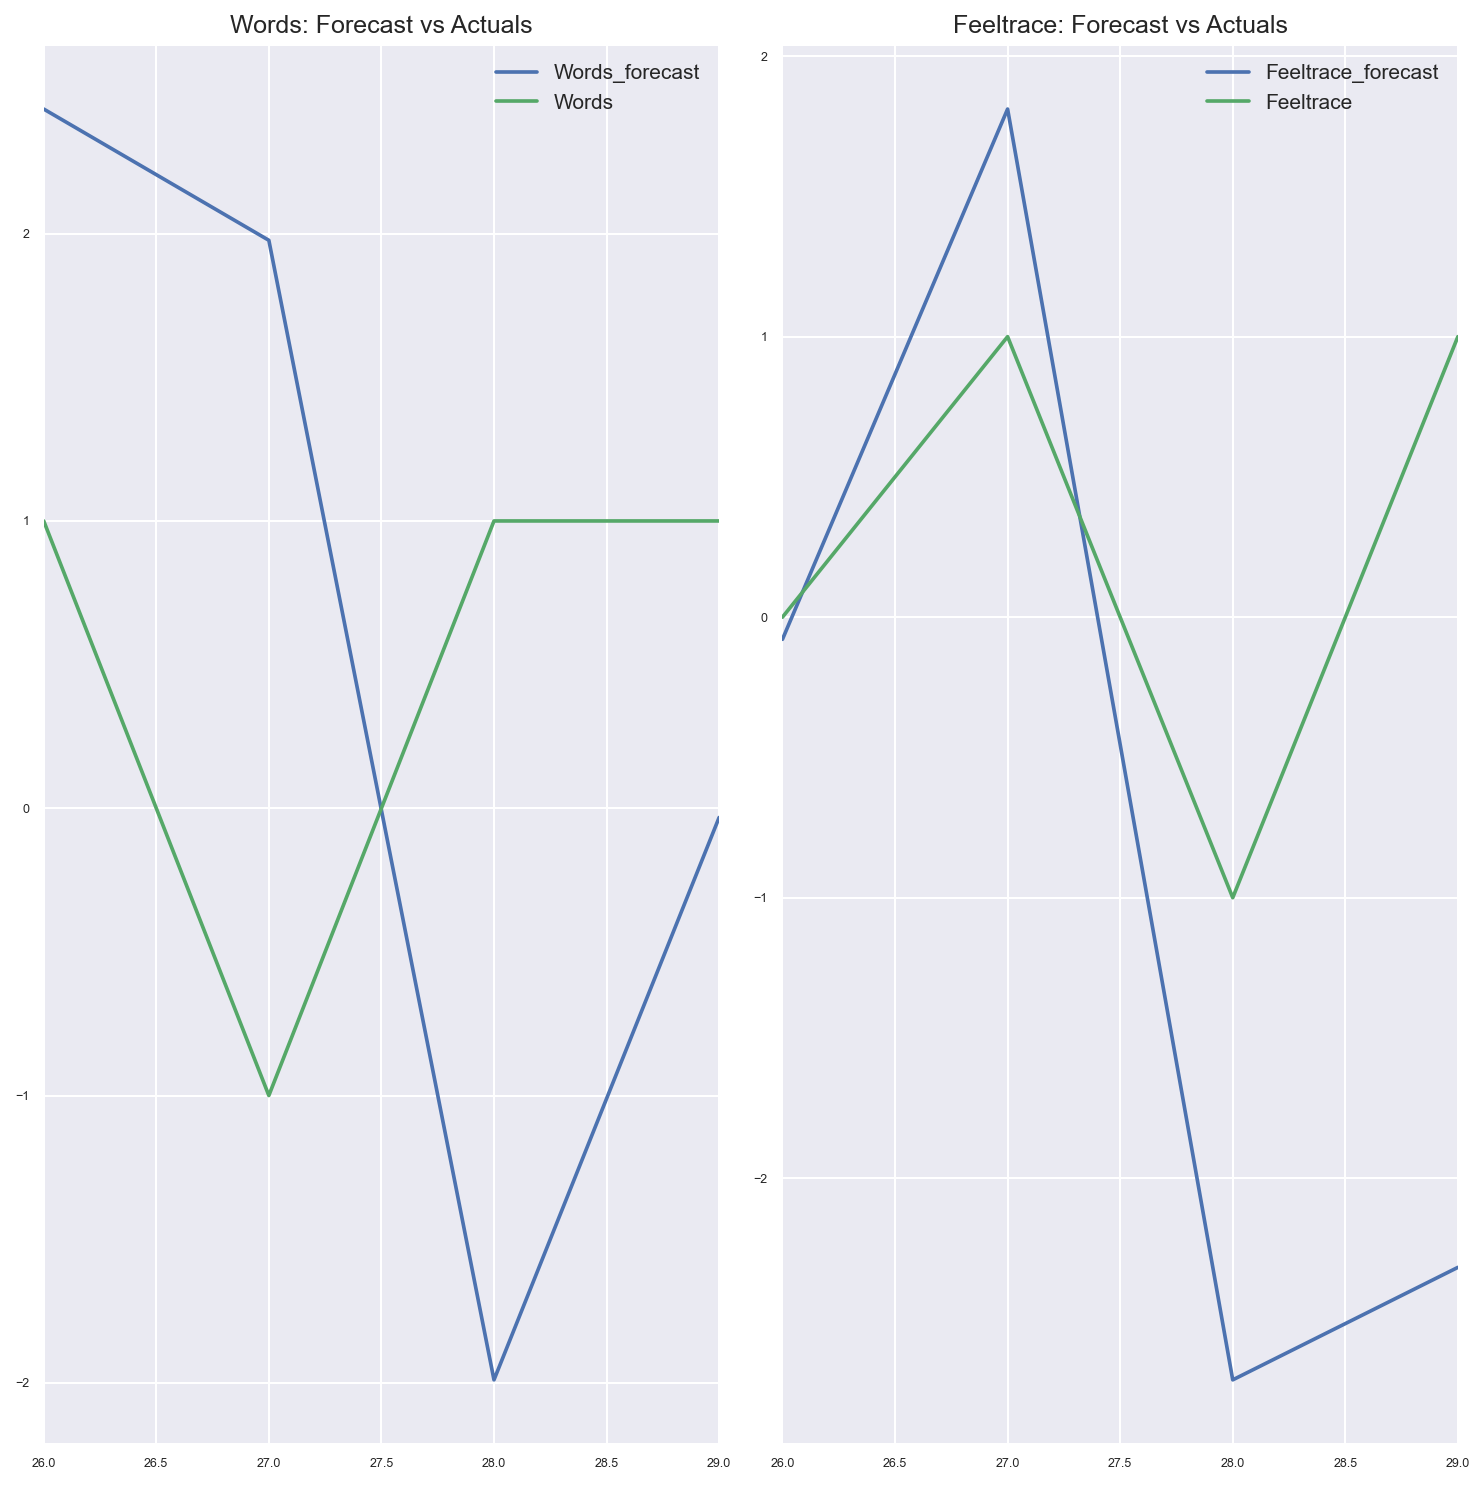

In [98]:
# The forecasts are generated but it is on the scale of the training data used by 
# the model. So, to bring it back up to its original scale, you need to de-difference 
# it as many times you had differenced the original input data.

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:     
        if 'Timestamp' in col:
            continue
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
df_results.loc[:, ['Words_1d', 'Feeltrace_1d']]

#---------------------------
# plot forecasts
#---------------------------


fig, axes = plt.subplots(nrows=int(len(p10_agg_data.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(p10_agg_data[['Words', 'Feeltrace']].columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

##### Accuracy

In [99]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Words')
accuracy_prod = forecast_accuracy(df_results['Words_forecast'].values, df_test['Words'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: Feeltrace')
accuracy_prod = forecast_accuracy(df_results['Feeltrace_forecast'].values, df_test['Feeltrace'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: Words
mape :  2.1082
me :  0.0972
mae :  2.1082
mpe :  -1.3913
rmse :  2.287
corr :  -0.4531
minmax :  1.5292

Forecast Accuracy of: Feeltrace
mape :  inf
me :  -1.076
mae :  1.4817
mpe :  -inf
rmse :  1.9122
corr :  0.502
minmax :  inf


/var/folders/bl/2tw1vrc12mv_hqpbdf1j3wkw0000gn/T/ipykernel_62330/1231121430.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
/var/folders/bl/2tw1vrc12mv_hqpbdf1j3wkw0000gn/T/ipykernel_62330/1231121430.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
/var/folders/bl/2tw1vrc12mv_hqpbdf1j3wkw0000gn/T/ipykernel_62330/1231121430.py:14: RuntimeWarning: divide by zero encountered in true_divide
  minmax = 1 - np.mean(mins/maxs)             # minmax


In [100]:
model_fitted.coefs

array([[[-0.01130686, -0.73244081],
        [ 0.57236544, -1.04899342]],

       [[-0.19728086,  0.06066069],
        [-0.30363155, -0.59202253]],

       [[-0.68014208, -0.86408763],
        [-0.44420634, -0.98514756]],

       [[-0.28915429,  0.11109575],
        [-0.07022896, -0.01449273]],

       [[-0.66005976,  0.15108138],
        [ 0.11145259, -0.25758653]],

       [[-0.29073581, -0.74118144],
        [ 0.55829852, -0.69214343]],

       [[ 0.40736375, -0.70248155],
        [ 0.16381727,  0.14359025]]])

## All participants

### Downsampling the continuous annotation

Before time series analysis can be performed, we must downsample the feeltrace to match the sample size of the interview words (or upsample the interview words):
- $\text{Fs}_{\text{feeltrace}} = 30$Hz
- $\text{Fs}_{\text{calibrated words}} \approx 0.05$Hz

In [251]:
def scale(X, min_=0, max_=200):
    return (X - min_)/(max_ - min_)

In [316]:
n_windows = []
granger_p_values = []
cointegration_p_values = []
pearsons_corr = []
var_models = []

for (p_words, p_feeltrace) in zip(words_list, feeltrace_list):
    p_words = p_words.copy()
    p_feeltrace = p_feeltrace.copy()

    p_words.Values = scale(p_words.Values)
    p_feeltrace.Feeltrace = scale(p_feeltrace.Feeltrace)
    
    timestamps = p_words.Timestamps.rolling(2).mean().dropna().reset_index(drop=True)
    timestamps.head()
    
    idxs = []

    for timestamp in timestamps:
        arr = p_feeltrace.Timestamps.to_numpy().astype(int)
        dist = (arr - timestamp)**2
        idx = tuple(np.argwhere(dist == np.min(dist))[0])
        idxs.append(idx[0])
    
    feeltrace_timestamps = list(p_feeltrace.loc[idxs, 'Timestamps'].rolling(2).mean().reset_index(drop=True))

    # add first timestamp
    feeltrace_timestamps[0] = p_feeltrace.loc[idxs[0], 'Timestamps'] / 2

    # add last timestamp
    feeltrace_timestamps.append((p_feeltrace.Timestamps.iloc[-1] + p_feeltrace.loc[idxs[-1], 'Timestamps']) / 2)

    feeltrace_timestamps = pd.Series(feeltrace_timestamps)
    
    # make sure both series are the same length
    assert(len(feeltrace_timestamps) == len(p_words.Timestamps))
    
    n_windows.append({'p_number': p_words.p_number[0], 'n_windows': len(feeltrace_timestamps)})
    
    p_feeltrace_agg_mean = pd.DataFrame()

    mean_feeltrace = []

    # first window
    mean_feeltrace.append(p_feeltrace.Feeltrace.loc[:idxs[0]].mean())

    # middle windows
    for (prev_idx, idx) in zip(idxs[:-1], idxs[1:]):
        mean_feeltrace.append(p_feeltrace.Feeltrace.loc[prev_idx:idx].mean())

    # last window
    mean_feeltrace.append(p_feeltrace.Feeltrace.loc[idxs[-1]:].mean())

    # make sure both feeltrace and interview series are the same size
    assert(len(mean_feeltrace) == len(p_words.Values))

    p_feeltrace_agg_mean['Timestamps'] = feeltrace_timestamps
    p_feeltrace_agg_mean['Feeltrace'] = mean_feeltrace
    
    p_feeltrace_agg_slope = pd.DataFrame()

    slope_feeltrace = []

    # first window
    slope_feeltrace.append(change_direction(p_feeltrace.Feeltrace[:idxs[0]], p_feeltrace.Timestamps[:idxs[0]]))

    # middle windows
    for (prev_idx, idx) in zip(idxs[:-1], idxs[1:]):
        slope_feeltrace.append(change_direction(p_feeltrace.Feeltrace.loc[prev_idx:idx], p_feeltrace.Timestamps.loc[prev_idx:idx]))

    # last window
    slope_feeltrace.append(change_direction(p_feeltrace.Feeltrace.loc[idxs[-1]:], p_feeltrace.Timestamps.loc[idxs[-1]:]))

    # make sure both feeltrace and interview series are the same size
    assert(len(slope_feeltrace) == len(p_words.Values))

    p_feeltrace_agg_slope['Timestamps'] = feeltrace_timestamps
    p_feeltrace_agg_slope['Feeltrace'] = slope_feeltrace
    p_feeltrace_agg_slope.head()
    
    p_feeltrace_agg_mean_slope = pd.DataFrame()

    mean_feeltrace_words = []
    indexes = list(p_feeltrace_agg_mean.index)

    # middle windows
    for (prev_idx, idx) in zip(indexes[:-1], indexes[1:]):
        mean_feeltrace_words.append(change_direction(p_feeltrace_agg_mean.Feeltrace.loc[prev_idx:idx], p_feeltrace_agg_mean.Timestamps.loc[prev_idx:idx]))

    p_feeltrace_agg_mean_slope['Feeltrace'] = mean_feeltrace_words
    p_feeltrace_agg_mean_slope['Timestamps'] = timestamps
    p_feeltrace_agg_mean_slope.head()
    
    p_words_agg_slope = pd.DataFrame()

    slope_words = []
    indexes = list(p_words.index)

    # middle windows
    for (prev_idx, idx) in zip(indexes[:-1], indexes[1:]):
        slope_words.append(change_direction(p_words.Values.loc[prev_idx:idx], p_words.Timestamps.loc[prev_idx:idx]))

    p_words_agg_slope['Values'] = slope_words
    p_words_agg_slope['Timestamps'] = timestamps
    p_words_agg_slope.head()
    
    p_agg_data = pd.DataFrame()
    p_agg_data['Timestamps'] = p_words_agg_slope['Timestamps'].copy()
    p_agg_data['Words'] = p_words_agg_slope['Values'].copy()
    p_agg_data['Feeltrace'] = p_feeltrace_agg_mean_slope['Feeltrace'].copy()
    
    maxlag = 1
    
    while True:
        try:
            grangers_causation_matrix(p_agg_data[['Words', 'Feeltrace']], variables = p_agg_data[['Words', 'Feeltrace']].columns) 
            maxlag+=1
        except ValueError:
            maxlag-=1
            granger_p_values.append(grangers_causation_matrix(p_agg_data[['Words', 'Feeltrace']], variables = p_agg_data[['Words', 'Feeltrace']].columns))
            break
            
    cointegration_p_values.append(cointegration_test(p_agg_data[['Words', 'Feeltrace']]))
    pearsons_corr.append(p_agg_data[['Words', 'Feeltrace']].corr())
    
    # The VAR model will be fitted on df_train and then used to forecast the next 4 
    # observations. These forecasts will be compared against the actuals present in 
    # test data.


    nobs = 4
    df_train, df_test = p_agg_data[0:-nobs], p_agg_data[-nobs:]

    # Check size
    model = VAR(df_train[['Words', 'Feeltrace']])

    maxlag = 1

    while True:
        try:
            x = model.select_order(maxlags=maxlag)
            maxlag+=1
        except ValueError:
            maxlag-=1
            x = model.select_order(maxlags=maxlag)
            model_fitted = model.fit(maxlag)
            break

    var_models.append([x, model_fitted])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Words  ::  25.09     > 12.3212   =>   True
Feeltrace ::  5.58      > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Words  ::  13.6      > 12.3212   =>   True
Feeltrace ::  6.28      > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Words  ::  9.38      > 12.3212   =>   False
Feeltrace ::  0.2       > 4.1296    =>   False
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Words  ::  11.66     > 12.3212   =>   False
Feeltrace ::  1.91      > 4.1296    =>   False
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Words  ::  9.11      > 12.3212   =>   False
Feeltrace ::  1.15      > 4.1296    =>   False
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Words  ::  17.7

/Users/rubiarg/.virtualenvs/cpsc554x/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/vecm.py:726: RuntimeWarning: invalid value encountered in log
  tmp = np.log(iota - a)[i:]
/Users/rubiarg/.virtualenvs/cpsc554x/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/vecm.py:728: RuntimeWarning: invalid value encountered in log
  lr2[i] = -t * np.log(1 - a[i])


Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Words  ::  nan       > 12.3212   =>   False
Feeltrace ::  413.21    > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Words  ::  16.63     > 12.3212   =>   True
Feeltrace ::  5.62      > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Words  ::  18.88     > 12.3212   =>   True
Feeltrace ::  6.86      > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Words  ::  18.4      > 12.3212   =>   True
Feeltrace ::  8.45      > 4.1296    =>   True


The number of windows corresponds to the number of words each participant used:

In [320]:
n_windows = pd.DataFrame(n_windows)
n_windows['n_windows'].describe()

count    16.000000
mean     36.875000
std       7.736278
min      19.000000
25%      32.000000
50%      39.000000
75%      41.000000
max      48.000000
Name: n_windows, dtype: float64

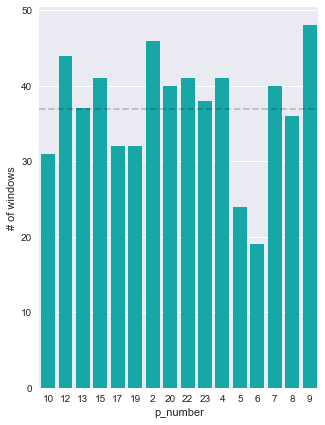

In [312]:
plt.figure(figsize=(5,7));
sns.barplot(data=n_windows, x='p_number', y='n_windows', color='c');
plt.ylabel('# of windows');
plt.axhline(n_windows['n_windows'].mean(), c='k', alpha=0.2, linestyle='dashed');

All results in the next sections are ordered according to p_number:

In [321]:
n_windows

,p_number,n_windows
0,10,31
1,12,44
2,13,37
3,15,41
4,17,32
5,19,32
6,2,46
7,20,40
8,22,41
9,23,38


### Granger Causality

TODO: summarize

In [313]:
for value in granger_p_values:
    print(value < 0.05)

             Words_x  Feeltrace_x
Words_y        False         True
Feeltrace_y     True        False
             Words_x  Feeltrace_x
Words_y        False         True
Feeltrace_y     True        False
             Words_x  Feeltrace_x
Words_y        False         True
Feeltrace_y    False        False
             Words_x  Feeltrace_x
Words_y        False         True
Feeltrace_y    False        False
             Words_x  Feeltrace_x
Words_y        False         True
Feeltrace_y     True        False
             Words_x  Feeltrace_x
Words_y        False         True
Feeltrace_y    False        False
             Words_x  Feeltrace_x
Words_y        False        False
Feeltrace_y     True        False
             Words_x  Feeltrace_x
Words_y        False         True
Feeltrace_y    False        False
             Words_x  Feeltrace_x
Words_y        False         True
Feeltrace_y    False        False
             Words_x  Feeltrace_x
Words_y        False         True
Feeltrace_y   

### Cointegration
TODO: summarize

In [314]:
cointegration_p_values

[[{'Words': [25.090662611093716, 12.3212, True]},
  {'Feeltrace': [5.576373930313893, 4.1296, True]}],
 [{'Words': [13.603258915700817, 12.3212, True]},
  {'Feeltrace': [6.276792850899008, 4.1296, True]}],
 [{'Words': [9.379655735708436, 12.3212, False]},
  {'Feeltrace': [0.19573343693180334, 4.1296, False]}],
 [{'Words': [11.65595996186797, 12.3212, False]},
  {'Feeltrace': [1.9116588301250044, 4.1296, False]}],
 [{'Words': [9.111958373184791, 12.3212, False]},
  {'Feeltrace': [1.1524863548082218, 4.1296, False]}],
 [{'Words': [17.78696696048187, 12.3212, True]},
  {'Feeltrace': [2.973484719112668, 4.1296, False]}],
 [{'Words': [19.34003040400524, 12.3212, True]},
  {'Feeltrace': [5.4733836576333665, 4.1296, True]}],
 [{'Words': [15.928669428541928, 12.3212, True]},
  {'Feeltrace': [3.5248468516296514, 4.1296, False]}],
 [{'Words': [16.968590425296398, 12.3212, True]},
  {'Feeltrace': [3.8884005773847585, 4.1296, False]}],
 [{'Words': [24.97404578313827, 12.3212, True]},
  {'Feeltrace

### Pearson's correlation

TODO: calculate significance

In [317]:
pearsons_corr

[              Words  Feeltrace
 Words      1.000000   0.365165
 Feeltrace  0.365165   1.000000,
               Words  Feeltrace
 Words      1.000000  -0.272041
 Feeltrace -0.272041   1.000000,
               Words  Feeltrace
 Words      1.000000   0.055989
 Feeltrace  0.055989   1.000000,
               Words  Feeltrace
 Words      1.000000   0.035617
 Feeltrace  0.035617   1.000000,
               Words  Feeltrace
 Words      1.000000   0.012927
 Feeltrace  0.012927   1.000000,
               Words  Feeltrace
 Words      1.000000   0.277778
 Feeltrace  0.277778   1.000000,
               Words  Feeltrace
 Words      1.000000   0.182896
 Feeltrace  0.182896   1.000000,
               Words  Feeltrace
 Words      1.000000   0.135889
 Feeltrace  0.135889   1.000000,
               Words  Feeltrace
 Words      1.000000   0.069471
 Feeltrace  0.069471   1.000000,
               Words  Feeltrace
 Words      1.000000  -0.078489
 Feeltrace -0.078489   1.000000,
               Words  Feeltrac

#### VAR Model

TODO: 
- Summarize VAR model results
- Cluster using VAR coefficients

## Emotion dynamics analysis


### Defining emotion dynamics features
Refer to _Houben M, Van Den Noortgate W, Kuppens P. The relation between short-term emotion dynamics and psychological well-being: A meta-analysis. Psychological bulletin. 2015 Jul;141(4):901._

- **Emotional inertia:** refers to how well the intensity of an emotional state can be predicted from the emotional state at a previous moment.
- **Emotional instability:** refers to the magnitude of emotional changes from one moment to the next. An individual characterized by high levels of instability experiences larger emotional shifts from one moment to the next, resulting in a more unstable emotional life.
- **Emotional variability:** refers to the range or amplitude of someone’s emotional states across time. An individual characterized by higher levels of emotional variability experiences emotions that reach more extreme levels and shows larger emotional deviations from his or her average emotional level

In [102]:
class EmotionDynamics:
    def __init__(self, Fs=0.05, interval=300):
        self.lag = int(Fs*interval*1e-1) # feeltrace sampling rate x 300 ms

    def emotional_variability(self, X):
        return np.std(X)

    def emotional_instability(self, X):
        return np.sum((X[1:] - X[:-1])**2)/(len(X)-1) # MSSD

    def emotional_inertia(self, X, lag=None):
        if lag is None:
            lag = self.lag
        return stattools.acf(X, nlags=lag)[lag] # Autocorrelation
    
    def get_parameters(self, X):
        X = np.array(X)
        parameters = {'Inertia':'', 'Instability':'', 'Variability':''}
        parameters['Inertia'] = self.emotional_inertia(X)
        parameters['Instability'] = self.emotional_instability(X)
        parameters['Variability'] = self.emotional_variability(X)
        return parameters

In [103]:
ED = EmotionDynamics(Fs=0.05)
ED.get_parameters(p10_words['Values'])

{'Inertia': -0.058245294276545984,
 'Instability': 0.11847916666666665,
 'Variability': 0.23778154351203037}

In [104]:
words_data = []
for subject in words_list:
    calibrated_values = np.array(subject['Values'])
    ed = ED.get_parameters(calibrated_values)
    ed['p_number'] = subject['p_number'][0]
    ed['pass'] = 'interview'
    words_data.append(ed)
words_data = pd.DataFrame(words_data)
words_data.head()

,Inertia,Instability,Variability,p_number,pass
0,-0.058245,4739.166667,47.556309,p10,interview
1,-0.037667,4309.883721,45.126086,p12,interview
2,0.042847,4868.750000,49.910073,p13,interview
3,-0.182514,2575.000000,33.046305,p15,interview
4,0.240929,2970.967742,43.546121,p17,interview


In [105]:
ED = EmotionDynamics(Fs=30)
feeltrace_data = []
for subject in feeltrace_list:
    feeltrace = np.array(subject['Feeltrace'])
    ed = ED.get_parameters(feeltrace)
    ed['p_number'] = subject['p_number'][0]
    ed['pass'] = 'feeltrace'
    feeltrace_data.append(ed)
    
feeltrace_data = pd.DataFrame(feeltrace_data)
feeltrace_data.head()

,Inertia,Instability,Variability,p_number,pass
0,0.017359,0.593234,32.349176,p10,feeltrace
1,0.127506,1.278632,49.077727,p12,feeltrace
2,0.111697,0.951712,38.263004,p13,feeltrace
3,0.087622,1.989445,40.816129,p15,feeltrace
4,-0.005488,0.761333,42.022961,p17,feeltrace


In [106]:
X = pd.concat([words_data, feeltrace_data]).reset_index(drop=True)
X

,Inertia,Instability,Variability,p_number,pass
0,-0.058245,4739.166667,47.556309,p10,interview
1,-0.037667,4309.883721,45.126086,p12,interview
2,0.042847,4868.750000,49.910073,p13,interview
3,-0.182514,2575.000000,33.046305,p15,interview
4,0.240929,2970.967742,43.546121,p17,interview
5,0.205085,2337.096774,38.247434,p19,interview
6,0.079935,2387.777778,36.376685,p2,interview
7,-0.060902,3267.307692,39.285613,p20,interview
8,-0.079603,2957.500000,37.608064,p22,interview
9,0.009257,3268.243243,40.209157,p23,interview


### Data preprocessing: scaling
Standardize features by removing the mean and scaling to unit variance.

In [107]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [108]:
X_feeltrace = scaler.fit_transform(feeltrace_data[['Inertia', 'Instability', 'Variability']])
X_feeltrace = pd.DataFrame(X_feeltrace, columns=['Inertia', 'Instability', 'Variability'])
X_feeltrace['p_number'] = feeltrace_data['p_number']
X_feeltrace['pass'] = feeltrace_data['pass']
X_feeltrace

,Inertia,Instability,Variability,p_number,pass
0,-0.527612,-1.097853,-0.950685,p10,feeltrace
1,0.187769,0.930514,1.480287,p12,feeltrace
2,0.085095,-0.036975,-0.091295,p13,feeltrace
3,-0.071268,3.034094,0.279722,p15,feeltrace
4,-0.675998,-0.600382,0.455097,p17,feeltrace
5,-0.562169,1.039313,0.107712,p19,feeltrace
6,-0.202338,-0.738683,0.096802,p2,feeltrace
7,1.236198,-0.123969,-0.827949,p20,feeltrace
8,-1.526199,0.273190,-0.064174,p22,feeltrace
9,0.379056,-0.462175,-1.436566,p23,feeltrace


In [109]:
X_words = scaler.fit_transform(words_data[['Inertia', 'Instability', 'Variability']])
X_words = pd.DataFrame(X_words, columns=['Inertia', 'Instability', 'Variability'])
X_words['p_number'] = words_data['p_number']
X_words['pass'] = words_data['pass']
X_words

,Inertia,Instability,Variability,p_number,pass
0,-0.303855,1.091102,1.239767,p10,interview
1,-0.141110,0.697543,0.773963,p12,interview
2,0.495656,1.209901,1.690916,p13,interview
3,-1.286661,-0.892967,-1.541383,p15,interview
4,2.062228,-0.529951,0.471130,p17,interview
5,1.778744,-1.111073,-0.544476,p19,interview
6,0.788972,-1.064609,-0.903045,p2,interview
7,-0.324868,-0.258272,-0.345487,p20,interview
8,-0.472769,-0.542298,-0.667025,p22,interview
9,0.230004,-0.257414,-0.168470,p23,interview


In [110]:
X_scaled = pd.concat([X_words, X_feeltrace]).reset_index(drop=True)

### Pairplot analysis

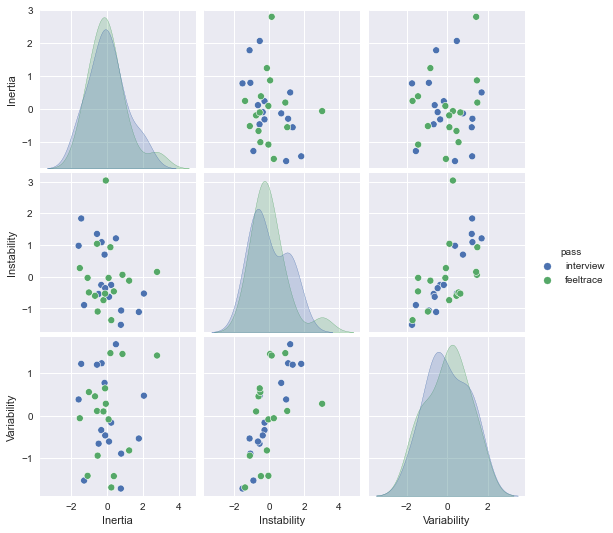

In [111]:
sns.pairplot(X_scaled, hue='pass');

In [112]:
abs(X_feeltrace[['Inertia', 'Instability', 'Variability']] - X_words[['Inertia', 'Instability', 'Variability']])

,Inertia,Instability,Variability
0,0.223757,2.188955,2.190452
1,0.328879,0.232971,0.706323
2,0.410561,1.246877,1.782211
3,1.215394,3.927061,1.821105
4,2.738226,0.070431,0.016032
5,2.340913,2.150386,0.652188
6,0.991310,0.325926,0.999847
7,1.561066,0.134303,0.482461
8,1.053430,0.815489,0.602851
9,0.149052,0.204760,1.268096


### 3D scatterplot

TODO: color according to labelling pass

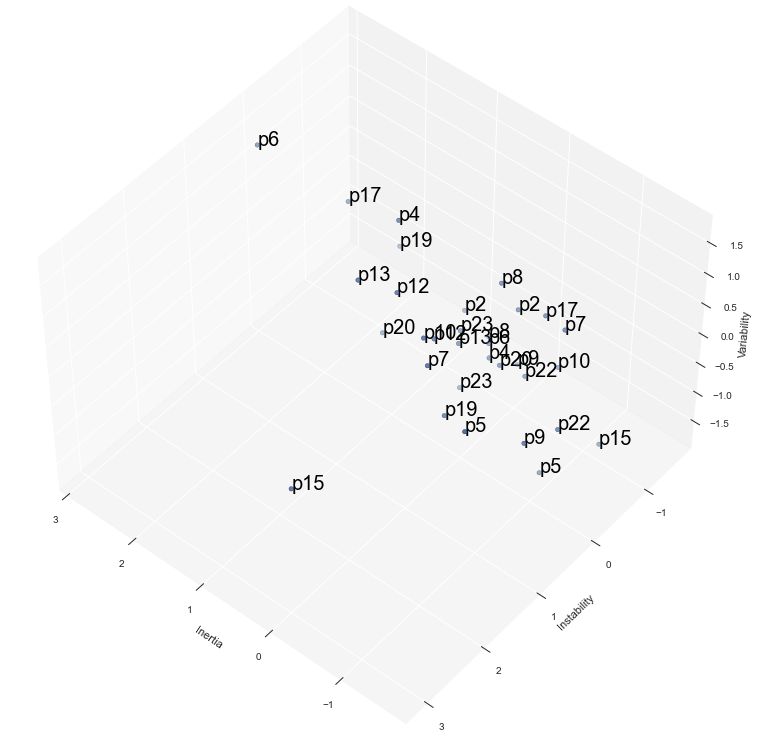

In [323]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=130, auto_add_to_figure=False, facecolor='w')
fig.add_axes(ax)

ax.scatter(X_scaled.Inertia, X_scaled.Instability, X_scaled.Variability, 
           cmap=plt.cm.nipy_spectral, edgecolor="k")

for (_, subject) in X_scaled.iterrows(): #plot each point + it's index as text above
    label = subject['p_number']
    ax.text(subject.Inertia,subject.Instability, subject.Variability,  '%s' % label, size=20, zorder=1,  
    color='k') 

ax.set_xlabel('Inertia')
ax.set_ylabel('Instability')
ax.set_zlabel('Variability')

plt.show()

### Principal Component Analysis

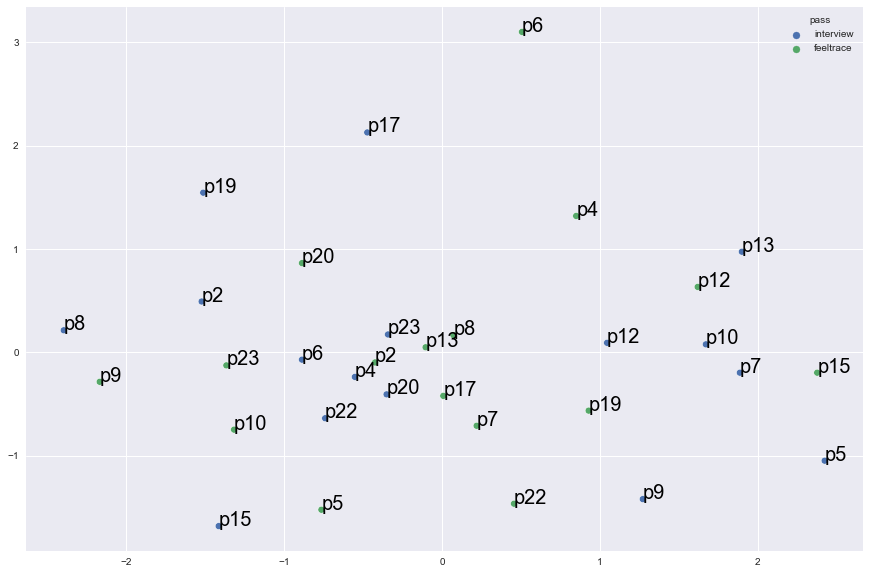

In [117]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled[['Inertia', 'Instability', 'Variability']])
X_PCA = pca.transform(X_scaled[['Inertia', 'Instability', 'Variability']])

plt.figure(figsize=(15,10))
sns.scatterplot(data=X, x=X_PCA[:, 0], y=X_PCA[:, 1], hue='pass');

for i, (_, subject) in enumerate(X_scaled.iterrows()): #plot each point + it's index as text above
    label = subject['p_number']
    plt.text(X_PCA[i, 0], X_PCA[i, 1],  '%s' % label, size=20, zorder=1,  
    color='k') 

In [129]:
X_PCA = pd.DataFrame(X_PCA, columns=['PC1', 'PC2'])
X_PCA['p_number'] = X_scaled['p_number']
X_PCA['pass'] = X_scaled['pass']
X_PCA.head()

,PC1,PC2,p_number,pass
0,1.671090,0.077657,p10,interview
1,1.045347,0.092455,p12,interview
2,1.899256,0.974139,p13,interview
3,-1.415254,-1.680991,p15,interview
4,-0.473970,2.128202,p17,interview


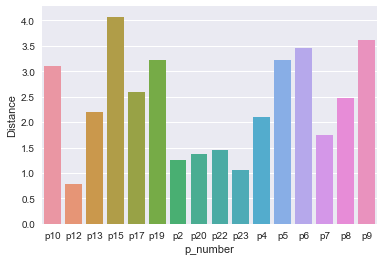

In [180]:
# TODO: fix colors

from scipy.spatial import distance

pass_distance = []

for subject in X_PCA.groupby('p_number'):
    subject = subject[1]
    subject_interview = subject.loc[subject['pass'] == 'interview', ['PC1', 'PC2']]
    subject_feeltrace = subject.loc[subject['pass'] == 'feeltrace', ['PC1', 'PC2']]
    pass_distance.append({'p_number': subject.p_number.iloc[0], 'Distance': distance.euclidean(subject_interview, subject_feeltrace)})

pass_distance = pd.DataFrame(pass_distance)
sns.barplot(data=pass_distance, x='p_number', y='Distance');

### Repeated Measures Analysis

In [124]:
X_scaled.pivot(columns='pass').to_csv('scaled_ed_per_pass.csv', index=False)

See Jamovi results.

### Gaussian Mixture Model

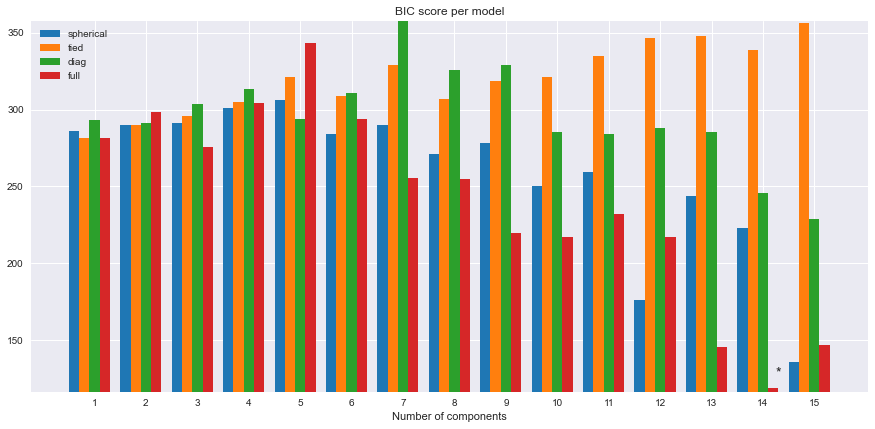

In [115]:
"""
================================
Gaussian Mixture Model Selection
================================

Gaussian Mixture Models using information-theoretic criteria (BIC).
Model selection concerns both the covariance type and the number of components in the model.
Unlike Bayesian procedures, such inferences are prior-free.

"""

import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 16)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X_scaled[['Inertia', 'Instability', 'Variability']])
        bic.append(gmm.bic(X_scaled[['Inertia', 'Instability', 'Variability']]))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(15, 15))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types);

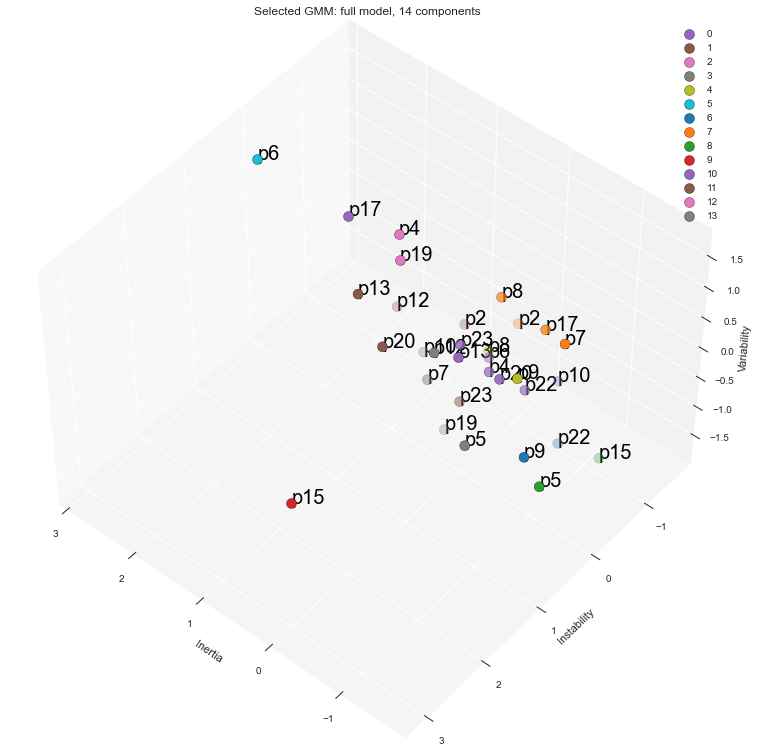

In [116]:
# TODO: Fix legend

# Plot the winner
fig = plt.figure(figsize=(15,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=130, auto_add_to_figure=False, facecolor='w')
fig.add_axes(ax)
Y_ = clf.predict(X_scaled[['Inertia', 'Instability', 'Variability']])

for i, (mean, color) in enumerate(zip(clf.means_, color_iter)):
    if not np.any(Y_ == i):
        continue
    ax.scatter(X_scaled.Inertia.loc[Y_ == i], X_scaled.Instability.loc[Y_ == i], 
               X_scaled.Variability.loc[Y_ == i], s=100, color=color, edgecolor="k")

for (_, subject) in X_scaled.iterrows(): #plot each point + it's index as text above
    label = subject['p_number']
    ax.text(subject.Inertia,subject.Instability, subject.Variability,  '%s' % label, size=20, zorder=1,  
    color='k') 
    
plt.legend(range(len(clf.means_)))
ax.set_xlabel('Inertia')
ax.set_ylabel('Instability')
ax.set_zlabel('Variability')

plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)


plt.show()